# Example of high-level interface

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

## Boilerplate code (to be absorbed in some form into SWYFT)

In [2]:
DEVICE = 'cuda:0'
NDIM = 2 # number of parameters
NBATCH = 64  # minibatch size
NTRAIN = 3000
NEPOCHS = NTRAIN // (NTRAIN // NBATCH) # training epochs
NMAXEPOCHS = 10
NSAMPLES = 3000 # traing batch size
NWORKERS = 4 # number of cpu workers for dataloader

In [3]:
class Data(torch.utils.data.Dataset):
    def __init__(self, xz):
        super().__init__()
        self.xz = xz

    def __len__(self):
        return len(self.xz)

    def __getitem__(self, idx):
        return self.xz[idx]

In [4]:
def gen_train_data(model, nsamples, zdim, mask = None):
    # Generate training data
    if mask is None:
        z = swyft.sample_hypercube(nsamples, zdim)
    else:
        z = swyft.sample_constrained_hypercube(nsamples, zdim, mask)
    
    xz = swyft.simulate_xz(model, z)
    dataset = Data(xz)
    
    return dataset

In [5]:
def get_net(combinations = None):
    pdim = 1 if combinations is None else len(combinations[0])
    net = swyft.Network(ydim = 3, pnum = NDIM, pdim = pdim).to(DEVICE)
    return net

In [6]:
def train(net, dataset, combinations = None):
    nvalid = 512
    ntrain = len(dataset) - nvalid
    dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [ntrain, nvalid])
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=NBATCH, num_workers=NWORKERS, pin_memory=True, drop_last=True)
    # Train!

    train_loss, valid_loss = [], []
    for i, lr in enumerate([1e-3, 1e-4, 1e-5]):
        print(f'LR Iter {i}', end="\r")
        tl, vl, sd = swyft.train(net, train_loader, valid_loader, early_stopping_patience = 20, lr = lr, max_epochs = NMAXEPOCHS, device=DEVICE, combinations = combinations)
        vl_minimum = min(vl)
        vl_min_idx = vl.index(vl_minimum)
        train_loss.append(tl[:vl_min_idx + 1])
        valid_loss.append(vl[:vl_min_idx + 1])
        net.load_state_dict(sd)

In [7]:
def posteriors(x0, net, dataset):
    x = torch.tensor(x0).float().to(DEVICE)
    z = torch.stack(swyft.get_z(dataset)).to(DEVICE)
    lnL = swyft.get_lnL(net, x, z.unsqueeze(-1))
    return z.cpu(), lnL.cpu()

In [8]:
# instatiate with model and x0
# run(nrounds_max, lr, init_mask, ntrain, early_stopping, maxepoch, threshold, storage, head, retain_networks)

def run(NROUNDS):
    netstore = []
    poststore = []
    datastore = []
    maskstore = []
    
    for i in range(NROUNDS):
        if i == 0:
            mask = None
        else:
            mask = swyft.Mask(net, torch.tensor(x0).float().to(DEVICE), 1e-3)
        net = get_net()
        dataset = gen_train_data(model, NSAMPLES, NDIM, mask = mask)
        train(net, dataset)
        zgrid, lnLgrid = posteriors(x0, net, dataset)
        
        datastore.append(dataset)
        netstore.append(net)
        poststore.append((zgrid, lnLgrid))
        maskstore.append(mask)
    
    return netstore, poststore, datastore, maskstore

## Toy generative model

In [9]:
def model(z, sigma = .03):
    T = np.array([[1, 1.], [0, 1.], [0, 1.]])
    n = np.random.randn(3)*sigma
    x = T.dot(z) + n
    return x

## Mock data generation

In [10]:
z0 = np.ones(2)*0.5
x0 = model(z0)
print(x0, z0)

[1.00684819 0.53080671 0.47481245] [0.5 0.5]


## Automatic inference 1-dim

In [11]:
results = run(2)

100%|██████████| 47/47 [00:00<00:00, 644.38it/s]


Constrained posterior volume: 0.06271555555555555


100%|██████████| 47/47 [00:00<00:00, 629.74it/s]


## Check posteriors

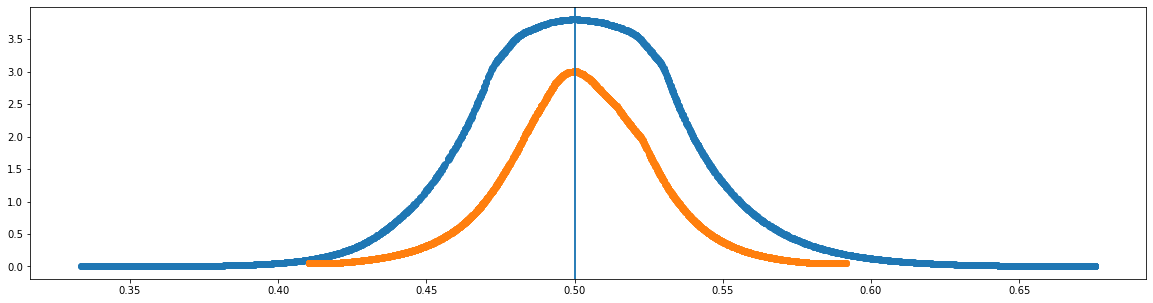

In [15]:
zgrid, lnLgrid = results[1][1]
plt.figure(figsize=(20, 5))
for i in range(NDIM):
    plt.axvline(z0[i])
    plt.scatter(zgrid[:,i], np.exp(lnLgrid[:,i]))

## Inference of 2-dim posteriors

In [13]:
#combinations = [[0, 1], [0, 1]]
#net3 = get_net(combinations = combinations)
#train(net3, dataset2, combinations = combinations)
#zgrid, lnLgrid = posteriors(x0, net3, dataset2)